In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.fft import dct
from scipy.fft import idctn
from scipy.fft import idct
from scipy.fft import dctn
from scipy.fft import fftn
from scipy.fft import ifftn
from scipy.sparse import random as sparse_random
from scipy.optimize import minimize
import cvxpy as cp

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def normalize(img):
    min_ = np.min(img)
    max_ = np.max(img)
    goal = (2**8-1) * (img - min_) / (max_ - min_) if (max_ - min_) != 0 else img
    goal = np.round(goal).astype(np.uint8)
    return goal
def bilateral(image,dia,sig_clr,sig_spc):
    return (cv2.bilateralFilter(image,dia,sig_clr,sig_spc))

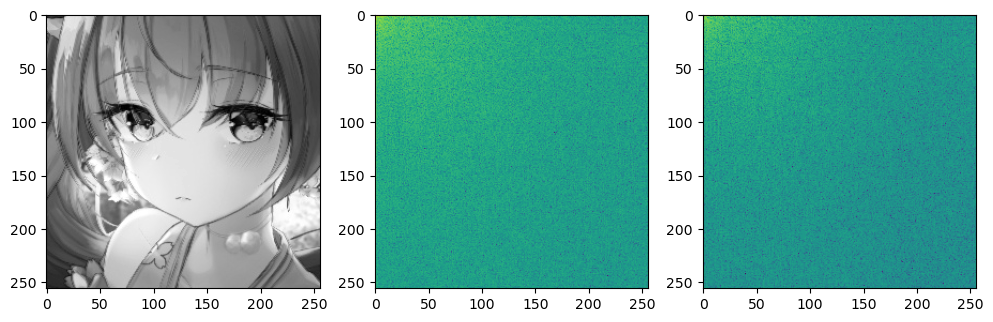

In [5]:
img = cv2.imread("1.jpg",cv2.IMREAD_GRAYSCALE)
img = np.float32(img)
img_idct = cv2.idct(np.float32(img))
#img_idct = np.abs(img_idct)
#img_idct = np.log10(img_idct )
#min_value = np.min(img_idct)
#max_value = np.max(img_idct)
#img_idct = 255 * (img_idct - min_value) / (max_value - min_value) if (max_value - min_value) != 0 else img_idct
img_from_idct = cv2.dct(np.float32(img))
#img_from_idct = np.round(img_from_idct).astype(np.uint8)
#img_from_idct = normalize(img_from_idct)
#img_from_idct -= img
#print(np.max(np.abs(img-img_from_idct)))
plt.figure(figsize = (12,4))
plt.subplot(131)
plt.imshow(img,cmap=plt.cm.gray)
plt.subplot(132)
plt.imshow(np.log(np.abs(img_idct)+1e-9))
plt.subplot(133)
plt.imshow(np.log(np.abs(img_from_idct)+1e-9))

In [6]:
#测试一些函数的用法
# img_ = img.flatten()
# d = 256
# img_ = np.float32(img_)
# idct_ = idct(img_)
# rec_ = np.round(dct(idct_)).astype(np.uint8)
# #print(np.shape(rec_))
# rec_ = rec_.reshape(256,256)
# assert(np.shape(img_) == (65536,))
# assert(np.shape(rec_) == (d,d))
# plt.figure(figsize = (12,4))
# plt.subplot(121)
# plt.imshow(rec_,cmap=plt.cm.gray)

In [12]:
def CS(image,ratio,alpha,size_d):
    assert(np.shape(image) == (size_d,size_d))
    #plt.imshow(image)
    x = image.flatten()
    x = np.float32(x)
    s = len(x)
    p = int(s*ratio)
    psi=dct(np.float32(np.eye(s)))
    np.random.seed(73)
    phi = np.random.choice([-1,1],size=(p,s))
    y = phi@x
    alpha_hat = cp.Variable(s)
    objective = cp.Minimize(cp.sum_squares(phi@psi@(alpha_hat).T - y) + alpha*cp.norm(alpha_hat, 1))
    problem = cp.Problem(objective)
    problem.solve()
    #x_hat = idct(alpha_hat.value)
    x_hat = psi@alpha_hat.value
    img_hat = x_hat.reshape(size_d,size_d)
#    plt.imshow(img_hat)
    #img_hat = normalize(img_hat)
    #img_hat = np.round(img_hat).astype(np.uint16)
    
    return img_hat,np.sum((phi@psi@(alpha_hat.value) - y)**2)

5.619399753417185e-05


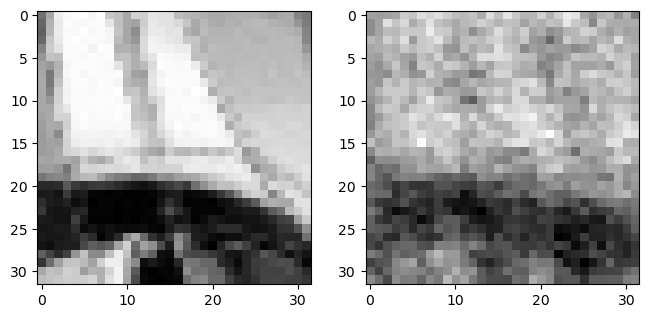

In [13]:
rec0,dy0 = CS(img[64:96,64:96],0.2,1,32)
# dia = 7
# sig_clr = 3
# sig_spc = 5
# bi_deno = cv2.bilateralFilter(rec0,dia,sig_clr,sig_spc)
plt.figure(figsize=(12,4))

print(dy0)
plt.subplot(131)
plt.imshow(img[64:96,64:96],cmap=plt.cm.gray)
plt.subplot(132)
plt.imshow(rec0,cmap=plt.cm.gray)
# plt.subplot(133)
# plt.imshow(bi_deno,cmap=plt.cm.gray)

In [16]:
def CS_whole(img,a,sr,d):
    _res_ = np.ones_like(img)
    _res_ = np.float32(_res_)
    dy=[]
    x_max,y_max = np.shape(img)
    #print(x_max,y_max)
    x = 0
    y = 0
    while (x<x_max):
        y = 0
        while(y<y_max):
            _res_[x:x+d,y:y+d],dyi = CS(image=img[x:x+d,y:y+d],ratio=sr,alpha=a,size_d=d)#调用CS分块处理
            dy.append(dyi)
            y += d
            #print(x,y)
        x += d
    print(max(dy),dy.index(max(dy)))
    return _res_

In [137]:
black = np.zeros_like(img)
# white = 255-black
res_black = np.zeros_like(img)
# res_white = res_black
# res_white_64 = CS(image=white[0:64,0:64],alpha=10,ratio=0.2,size_d=64)
res_black_64 = CS(image=black[0:64,0:64],alpha=1,ratio=0.2,size_d=64)

In [ ]:
black = np.zeros_like(img)
# white = 255-black
res_black = np.zeros_like(img)
# res_white = res_black
# res_white_64 = CS(image=white[0:64,0:64],alpha=10,ratio=0.2,size_d=64)
res_black_64 = CS(image=black[0:64,0:64],alpha=1,ratio=0.2,size_d=64)

6.93404e-21 -6.470597e-21


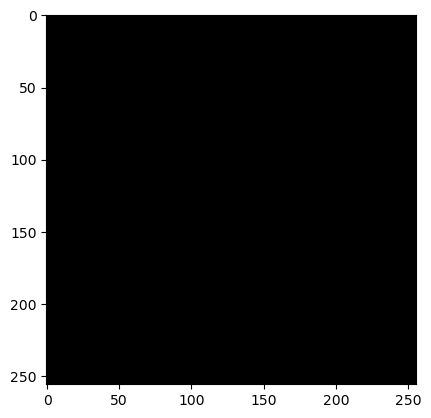

In [140]:
x_ = 0
y_ = 0
x_lim,y_lim = np.shape(img)
step = 64
res_black=np.float32(res_black)
while (x_<x_lim):
    y_ = 0
    while(y_<y_lim):
        res_black[x_:x_+step,y_:y_+step] = res_black_64
        y_ += step
    x_ += step
#res_black=normalize(res_black)
plt.imshow(np.round(res_black).astype(np.uint8),cmap="gray")
print(res_black.max(),res_black.min())

In [13]:
res_blk_int = normalize(res_black)
res_blk_int = np.uint8(res_blk_int)
#cv2.imwrite("res_black.png",res_blk_int)
# cv2.imwrite("res_white.png",res_white)
read_blk=cv2.imread("res_black.png",cv2.IMREAD_GRAYSCALE)
np.max(read_blk-res_blk_int)


0

1.5874334178987977e-05 13
311.5209 -16.65529


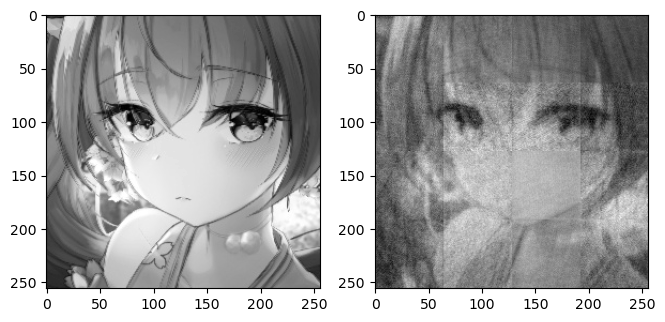

In [28]:
img = cv2.imread("1.jpg",cv2.IMREAD_GRAYSCALE)
img = np.float32(img)
res64 = CS_whole(img=img,a=1,sr=0.2,d=64)
# res64_fft = fftn(res64)
# blk_fft = fftn(res_black)#零输入输出的频域
# fltd_blk_ft_ = ifftn(res64_fft - blk_fft)#频域处理
# fltd_blk_ft_ = (np.real(fltd_blk_ft_))#uint32

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img,cmap="gray")
# plt.subplot(132)
# plt.imshow(normalize(fltd_blk_ft_),cmap="gray")
plt.subplot(132)
plt.imshow(res64,cmap="gray")
print(np.max(res64),np.min(res64))

In [33]:
cv2.imwrite("rec_1_adap.jpg",res64)

True

True

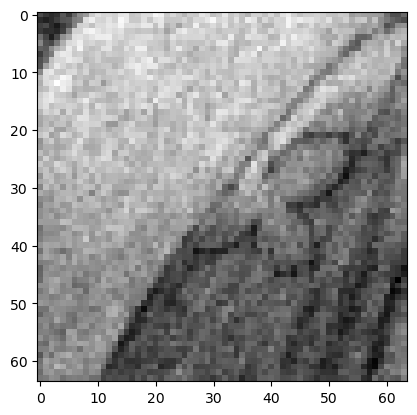

In [34]:
idx = 13
img_idx = img[64*(idx>>2):64*((idx>>2)+1),64*(idx&3):64*((idx&3)+1)]
res_idx,_ = CS(img_idx,0.4,1,64)
plt.imshow(res_idx,cmap="gray")
cv2.imwrite("adap_blk.jpg",res_idx)

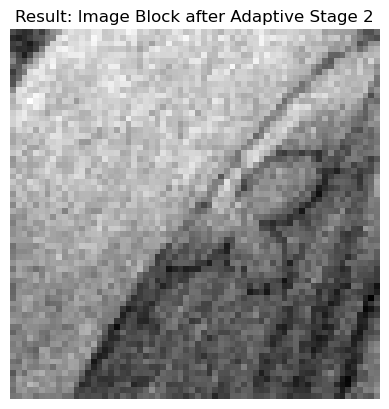

In [39]:
plt.title("Result: lmage Block after Adaptive Stage 2")
plt.axis("off")
plt.imshow(res_idx,cmap="gray")

True

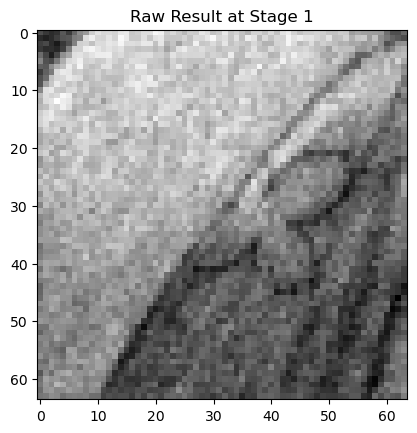

In [37]:
idx = 13
img_idx_raw = img[64*(idx>>2):64*((idx>>2)+1),64*(idx&3):64*((idx&3)+1)]
res_idx_raw,_ = CS(img_idx,0.2,1,64)
plt.title("Raw Result at Stage 1")
plt.imshow(res_idx,cmap="gray")
cv2.imwrite("adap_blk.jpg",res_idx)

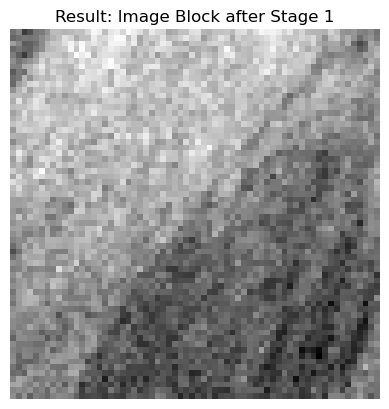

In [40]:
plt.title("Result: lmage Block after Stage 1")
plt.axis("off")
plt.imshow(res_idx_raw,cmap="gray")

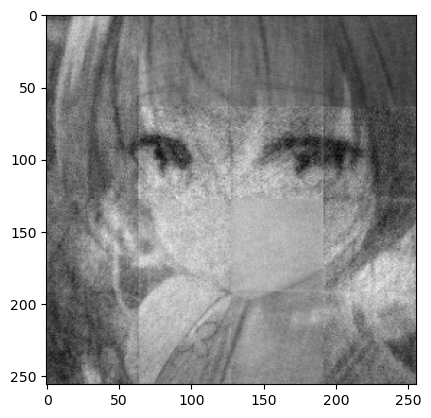

In [31]:
res64[64*(idx>>2):64*((idx>>2)+1),64*(idx&3):64*((idx&3)+1)] = res_idx
plt.imshow(res64,cmap="gray")

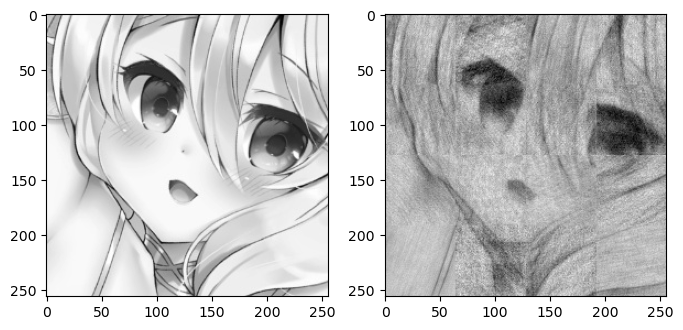

In [157]:
img2 = cv2.imread("44.jpg",cv2.IMREAD_GRAYSCALE)
img2 = np.float32(img2)
res2_64 = CS_whole(img=img2,a=1,sr=0.2,d=64)


plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img2,cmap="gray")
plt.subplot(122)
plt.imshow(res2_64,cmap="gray")


In [ ]:
root_dir="face_dataset/train"
raw_image_dir = os.path.join(root_dir, 'raw_images')
constructed_image_dir = os.path.join(root_dir, 'constructed_images')
all_files = os.listdir(constructed_image_dir)
image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
#openimg()
for idx, name in enumerate(image_files):
    CS_simulation(name,0.2).save(os.path.join(raw_image_dir, name))

In [161]:
cv2.imwrite("bw_1.png",img)

True

1045.7785339355469


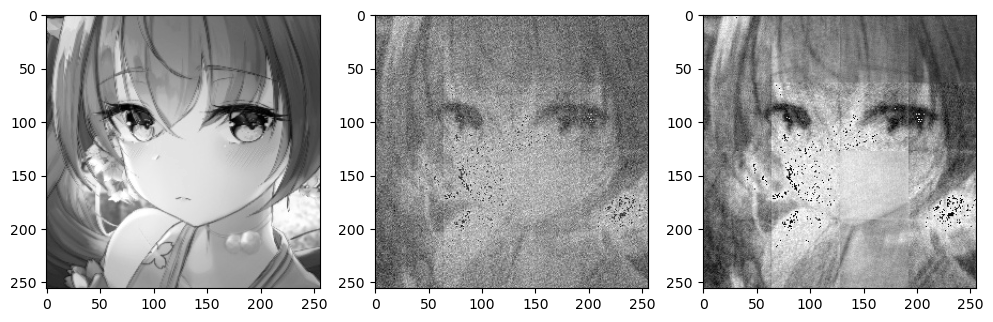

In [16]:
#频域去噪声
res_blk_int = normalize(res_black)#零输入转化为int32
blk_fft = fftn(res_black)
#fltd_blk_ft_ = normalize(fltd_blk_ft_)
fltd_blk_ft_ = ifftn(res64_fft - blk_fft)
fltd_blk_ft_ = normalize((np.real(fltd_blk_ft_)))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img,cmap="gray")
plt.subplot(132)
plt.imshow(fltd_blk_ft_,cmap="gray")
plt.subplot(133)
plt.imshow(res64,cmap="gray")
print(np.mean((res64-fltd_blk_ft_)**2))

In [ ]:
def _mse_(img1,img2):
    return (np.mean(img1-img2)**2)
def median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)
def gaussian_filter(image, kernel_size=3, sigma=0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

minimum = 10000
di = 1
sig_c = 1
sig_s = 1
for i in range(1,15):
    for j in range(1,20):
        for j in range(1,20):
            bi_res = cv2.fastNlMeansDenoising(fltd_blk_ft_, None, h=i, templateWindowSize=j, searchWindowSize=k)
            if (minimum>_mse_(img,bi_res)):
                minimum = _mse_(img,bi_res)
                di = i
                sig_c = j
                sig_s = k
bi_res = cv2.fastNlMeansDenoising(gray_image, None, h=di, templateWindowSize=sig_c, searchWindowSize=sig_s)
print(di,sig_c,sig_s)
plt.imshow(bi_res,cmap="gray")

256 256
0 64
0 128
0 192
0 256
64 64
64 128
64 192
64 256
128 64
128 128
128 192
128 256
192 64
192 128
192 192
192 256


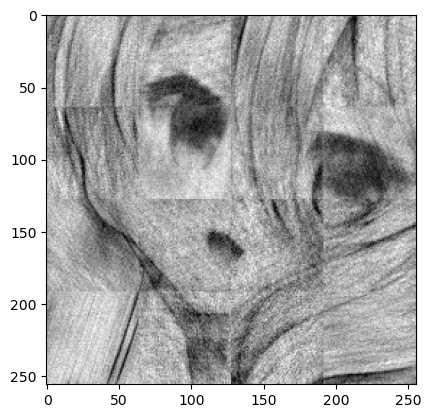

In [11]:
d = 64
x = 0
y = 0
al = 20
sr = 0.2
res = np.ones_like(img)
x_max,y_max = np.shape(img)
print(x_max,y_max)
while (x<x_max):
    y=0
    while(y<y_max):
        res[x:x+d,y:y+d] = CS(image=img[x:x+d,y:y+d],ratio=sr,alpha=al,size_d=d)
        y += d
        print(x,y)
    x += d
plt.imshow(res,cmap=plt.cm.gray)

256 256


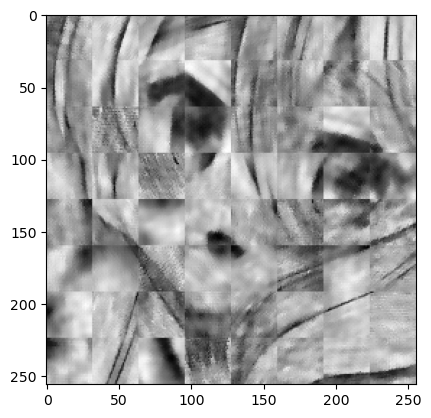

In [272]:
d = 32
x = 0
y = 0
al = 20
sr = 0.2
res32 = np.ones_like(img)
x_max,y_max = np.shape(img)
print(x_max,y_max)
while (x<x_max):
    y=0
    while(y<y_max):
        res32[x:x+d,y:y+d] = CS(image=img[x:x+d,y:y+d],ratio=sr,alpha=al,size_d=d)
        y += d
        #print(x,y)
    x += d
plt.imshow(res32,cmap=plt.cm.gray)

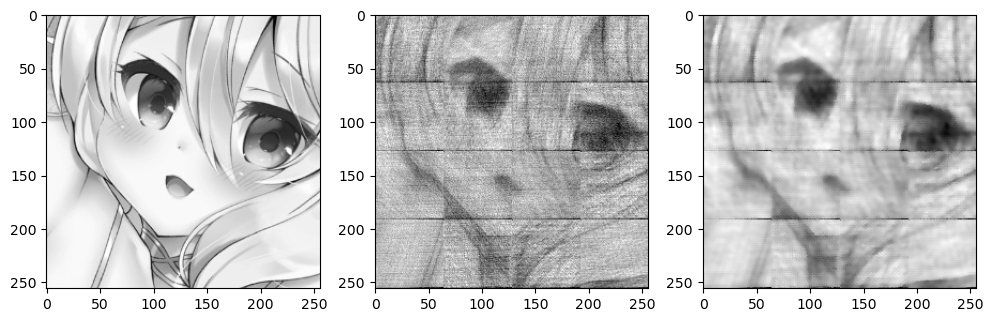

In [235]:
res_bil = bilateral(res,7,50,50)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img,cmap=plt.cm.gray)
plt.subplot(132)
plt.imshow(res,cmap=plt.cm.gray)
plt.subplot(133)
plt.imshow(res_bil,cmap=plt.cm.gray)

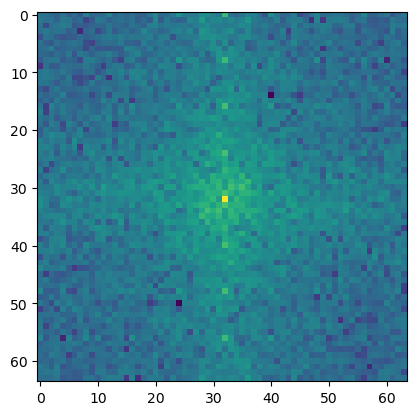

In [208]:
res_fft = np.fft.fft2(res) # take 2D DFT with default parameters
res_fft = np.fft.fftshift(res_fft) # shift low frequencies to center of plot
res_fft = abs(res_fft) # calculate magnitude of DFT
res_fft = np.log(res_fft + 1e-9)
plt.imshow(res_fft[96:160,96:160])

(256, 256)
0 64
0 128
0 192
0 256
64 64
64 128
64 192
64 256
128 64
128 128
128 192
128 256
192 64
192 128
192 192
192 256


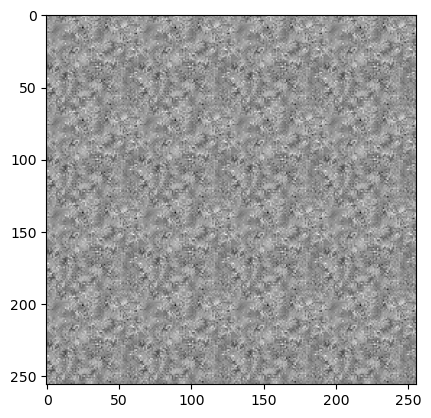

In [273]:
black = np.zeros_like(img)
print(black.shape)
white = 255-black
res_white = CS_whole(white,20,0.2,64)
# plt.imshow(res_white,cmap=plt.cm.gray)
res_black = CS_whole(black,20,0.2,64)
# plt.imshow(res_black,cmap=plt.cm.gray)

196 54


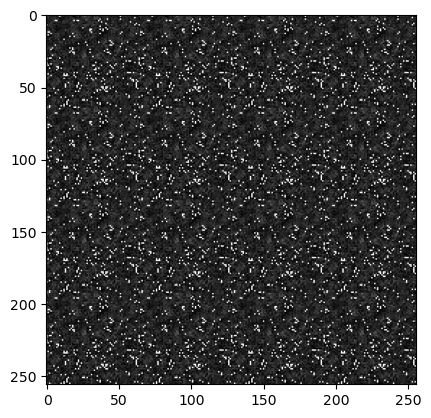

In [279]:
plt.imshow(res_white + res_black,cmap=plt.cm.gray)
print(np.max(res_white),np.min(res_black))

In [ ]:
res64 = CS_whole(img,20,0.2,64)
plt.imshow(res64,cmap=plt.cm.gray)

255 255
0 0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


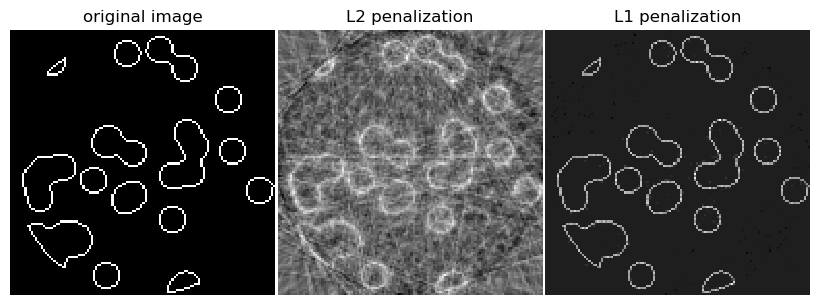

In [1]:
# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, sparse

from sklearn.linear_model import Lasso, Ridge


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)
min_value = np.min(rec_l1)
max_value = np.max(rec_l1)
rec_l1 = 255 * (rec_l1 - min_value) / (max_value - min_value) if (max_value - min_value) != 0 else rec_l1

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()